In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import numpy as np

plt.rcParams['font.family'] = 'P052'
plt.rcParams['font.serif'] = ['Times New Roman']

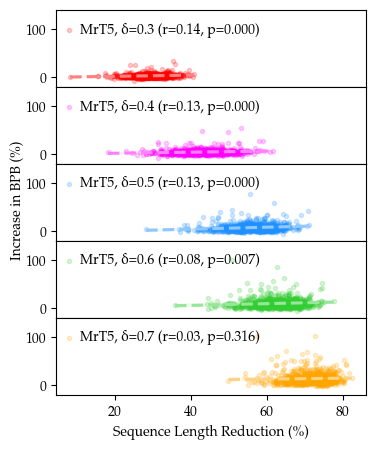

Average correlation coefficient: 0.103


In [74]:
def lighten_color(color, amount=0.4):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

def plot_correlation(dataframes, labels, colors, baseline_df, title):
    baseline_loss = baseline_df['Eval Cross Entropy Loss']
    fig, axes = plt.subplots(len(dataframes), 1, figsize=(4, 1 * len(dataframes)), sharex=True, sharey=True)
    if len(dataframes) == 1:  # Ensure axes object is iterable when only one dataframe is provided
        axes = [axes]
    correlations = []
    for ax, data, label, color in zip(axes, dataframes, labels, colors):
        data['Delta Cross Entropy Loss'] = (data['Eval Cross Entropy Loss'] - baseline_loss) / baseline_loss * 100
        # Calculate Pearson correlation coefficient and p-value
        correlation_coeff, p_value = sp.stats.pearsonr(data['Eval Percent Deleted Tokens'], data['Delta Cross Entropy Loss'])
        # Plot scatter
        ax.scatter(data['Eval Percent Deleted Tokens'], data['Delta Cross Entropy Loss'], alpha=0.2, color=color, label=f'{label} (r={correlation_coeff:.2f}, p={p_value:.3f})', marker='.')
        # Fit and plot regression line
        sns.regplot(x='Eval Percent Deleted Tokens', y='Delta Cross Entropy Loss', data=data, scatter=False, color=lighten_color(color, 0.5), ax=ax, line_kws={'linestyle': '--'})
        ax.set(ylabel='')
        ax.legend(loc='upper left', frameon=False, handlelength=0)

        correlations.append(correlation_coeff)
    plt.xlabel('Sequence Length Reduction (%)')
    plt.ylim(-20, 140)

    axes[-1].xaxis.set_tick_params(labelbottom=True)    # Show x-tick labels on the last subplot
    plt.subplots_adjust(hspace=0)                       # Remove vertical space between histograms
    fig.text(0.01, 0.5, 'Increase in BPB (%)', va='center', rotation='vertical')  # Overall y-label for the figure
    plt.savefig(f"figures/span_corruption_per_sample_{title}.pdf")
    plt.show()
    return correlations

def get_overall_correlation(dataframes, baseline_df):
    baseline_loss = baseline_df['Eval Cross Entropy Loss']
    cross_entropy_loss_deltas = []
    percent_deleted_tokens = []

    for data in dataframes:
        cross_entropy_loss_deltas.extend(list((data['Eval Cross Entropy Loss'] - baseline_loss) / baseline_loss))
        percent_deleted_tokens.extend(list(data['Eval Percent Deleted Tokens']))
    # Calculate Pearson correlation coefficient and p-value
    print(len(cross_entropy_loss_deltas), len(percent_deleted_tokens))
    correlation_coeff, p_value = sp.stats.pearsonr(cross_entropy_loss_deltas, percent_deleted_tokens)
    print(f"Overall correlation coefficient: {correlation_coeff:.2f}, p-value: {p_value:.3f}")

def fisher_z_average(correlations):
    """
    Computes the average of correlation coefficients using Fisher's Z transformation.

    Parameters:
    correlations (list of float): List of correlation coefficients.

    Returns:
    float: Average correlation coefficient.
    """
    # Step 1: Apply Fisher's Z transformation
    fisher_z = [0.5 * np.log((1 + r) / (1 - r)) for r in correlations]

    # Step 2: Compute the average of the Z-transformed values
    avg_fisher_z = np.mean(fisher_z)

    # Step 3: Apply the inverse Fisher transformation to get the average correlation
    avg_correlation = (np.exp(2 * avg_fisher_z) - 1) / (np.exp(2 * avg_fisher_z) + 1)

    return avg_correlation


def analyze_and_plot(file_paths, colors, labels, baseline_path, title, seed=86):
    # Sample 1000 examples from each dataset
    rng = np.random.default_rng(seed)
    sample_indices = rng.choice(10000, 1000, replace=False)

    dataframes = []
    for file_path in file_paths:
        df = pd.read_csv(file_path)
        df = df.loc[sample_indices].reset_index(drop=True)
        dataframes.append(df)

    baseline_df = pd.read_csv(baseline_path).loc[sample_indices].reset_index(drop=True)
    correlations = plot_correlation(dataframes, labels, colors, baseline_df, title)
    avg_correlation = fisher_z_average(correlations)
    print(f"Average correlation coefficient: {avg_correlation:.3f}")


base_file_path = 'eval_results/span_corruption_per_sample/MrT5/mrt5_span_corruption_multilingual_pi-cntrl{}%_seed{}.csv'
baseline_path = 'eval_results/span_corruption_per_sample/T5/t5_span_corruption_multilingual_seed76.csv'
alphas =  ["0.3", "0.4", "0.5", "0.6", "0.7"]
seeds = [16, 53, 40, 67, 51]
colors = ['red', 'magenta', 'dodgerblue', 'limegreen', 'orange'] #, 'orangered']  # Extend this list if more datasets are needed
file_paths = [base_file_path.format(int(float(a)*100), s) for a, s in zip(alphas, seeds)]
labels = [f"MrT5, δ={i}" for i in alphas]
analyze_and_plot(file_paths, colors, labels, baseline_path, "mrt5")

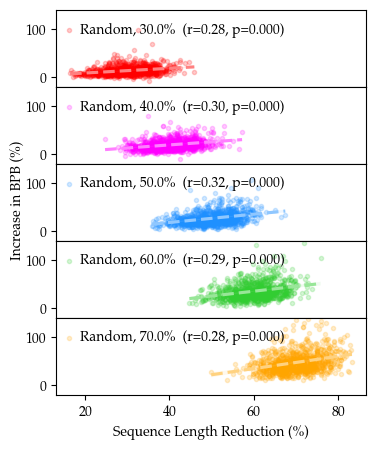

Average correlation coefficient: 0.295


In [75]:
base_file_path = 'eval_results/span_corruption_per_sample/RandomT5/randomt5_span_corruption_multilingual_{}%_seed{}.csv'
baseline_path = 'eval_results/span_corruption_per_sample/T5/t5_span_corruption_multilingual_seed76.csv'
alphas =  ["30", "40", "50", "60", "70"]
seeds = [54, 65, 109, 86, 595]
colors = ['red', 'magenta', 'dodgerblue', 'limegreen', 'orange'] #, 'orange', 'orangered']  # Extend this list if more datasets are needed
file_paths = [base_file_path.format(a, s) for a, s in zip(alphas, seeds)]
labels = [f"Random, {float(i)}% " for i in alphas]
analyze_and_plot(file_paths, colors, labels, baseline_path, "randomt5")